In [7]:
import matplotlib.pyplot as plt
import numpy as np
from pandas_datareader import data as pdr

In [8]:
class timeseries_anomaly_detection:
    def __init__(self, stock, start, end) -> None:
        self.download_data(stock, start, end)

    def normalize_data(self, data):
        #return data
        return (data - data.min()) / (data.max() - data.min())

    def download_data(self, ticker, start_date, end_date):
        self.data = pdr.get_data_yahoo(ticker, start_date, end_date)
        self.data = self.data.dropna()
        print(self.data.head())
        #normalize between 0 and 1
        self.data = self.normalize_data(self.data['Adj Close'])
        return self.data

    def rolling_average(self, data, window):
        roll = data.rolling(window).mean()
        #normalize between 0 and 1
        roll = self.normalize_data(roll)
        # correct for window size shift
        #roll = roll.shift(-window)
        return  roll

    def rolling_std(self, data, window):
        roll = data.rolling(window).std()
        #normalize between 0 and 1
        roll = self.normalize_data(roll)
        # correct for window size shift
        #roll = roll.shift(-window)
        return roll

    def exponential_smoothing(self, data, alpha):
        exp = data.ewm(alpha=alpha, adjust=False).mean()
        #normalize between 0 and 1
        exp = self.normalize_data(exp)
        return exp


    def lines_at_troughs(self, data, window):
        #find troughs
        troughs = data.rolling(window).min()
        #normalize between 0 and 1
        troughs = self.normalize_data(troughs)
        # correct for window size shift
        #troughs = troughs.shift(-window)
        return troughs

    def gradient_at_each_point(self, data, window):
        gradient = data.rolling(window).apply(lambda x: np.gradient(x))
        return gradient

    def gradient_up_or_down(self, data, window):
        gradient = self.gradient_at_each_point(data, window)
        gradient_up = gradient[gradient > 0]
        gradient_down = gradient[gradient < 0]
        return gradient_up, gradient_down

    def points_above_rollingaverage_and_bellow_rollingstd(self, data, window):
        rolling_mean = self.rolling_average(data, window)
        rolling_std = self.rolling_std(data, window)
        #find points above rolling mean and bellow rolling std
        # delete points with positive gradient
        points = data[(data > rolling_mean) & (data < rolling_std)] 
        #points = data[(self.data > rolling_mean) & (self.data < rolling_std)]
        return points

    def plot(self, window=20, alpha=0.5, plots = ['data', 'mean', 'std', 'exponential', 'troughs', 'bet_std_mean', 'gradient']):
        plt.figure(figsize=(30, 10))
        if 'data' in plots:
            plt.plot(self.data, label='Data')
        if 'mean' in plots:
            rolling_mean = self.rolling_average(self.data, window)
            plt.plot(rolling_mean, label='Rolling Mean')
        if 'std' in plots:
            rolling_std = self.rolling_std(self.data, window)
            plt.plot(rolling_std, label='Rolling Std')
        if 'exponential' in plots:
            exponential_smoothing = self.exponential_smoothing(self.data, alpha)
            plt.plot(exponential_smoothing, label='Exponential Smoothing')
        if 'troughs' in plots:
            troughs = self.lines_at_troughs(self.data, window)
            plt.plot(troughs, label='Lines at Troughs')
        if 'bet_std_mean' in plots:
            points = self.points_above_rollingaverage_and_bellow_rollingstd(self.data, window)
            # point y values should equal to data y values
            plt.plot(points, 'ro', label='Points above rolling mean and bellow rolling std')
            # plot these points with y-values = data y values
            
        
        plt.legend()
        #return all plots
        self.all_plots = plt.gcf()
        #del plot
        plt.close('all')
        return self.all_plots
    
    def show_plot(self):
        return self.all_plots

series = timeseries_anomaly_detection('AAPL', '2018-01-01', '2019-01-01')


                 High        Low       Open      Close       Volume  Adj Close
Date                                                                          
2018-01-02  43.075001  42.314999  42.540001  43.064999  102223600.0  40.950497
2018-01-03  43.637501  42.990002  43.132500  43.057499  118071600.0  40.943371
2018-01-04  43.367500  43.020000  43.134998  43.257500   89738400.0  41.133549
2018-01-05  43.842499  43.262501  43.360001  43.750000   94640000.0  41.601856
2018-01-08  43.902500  43.482498  43.587502  43.587502   82271200.0  41.447346


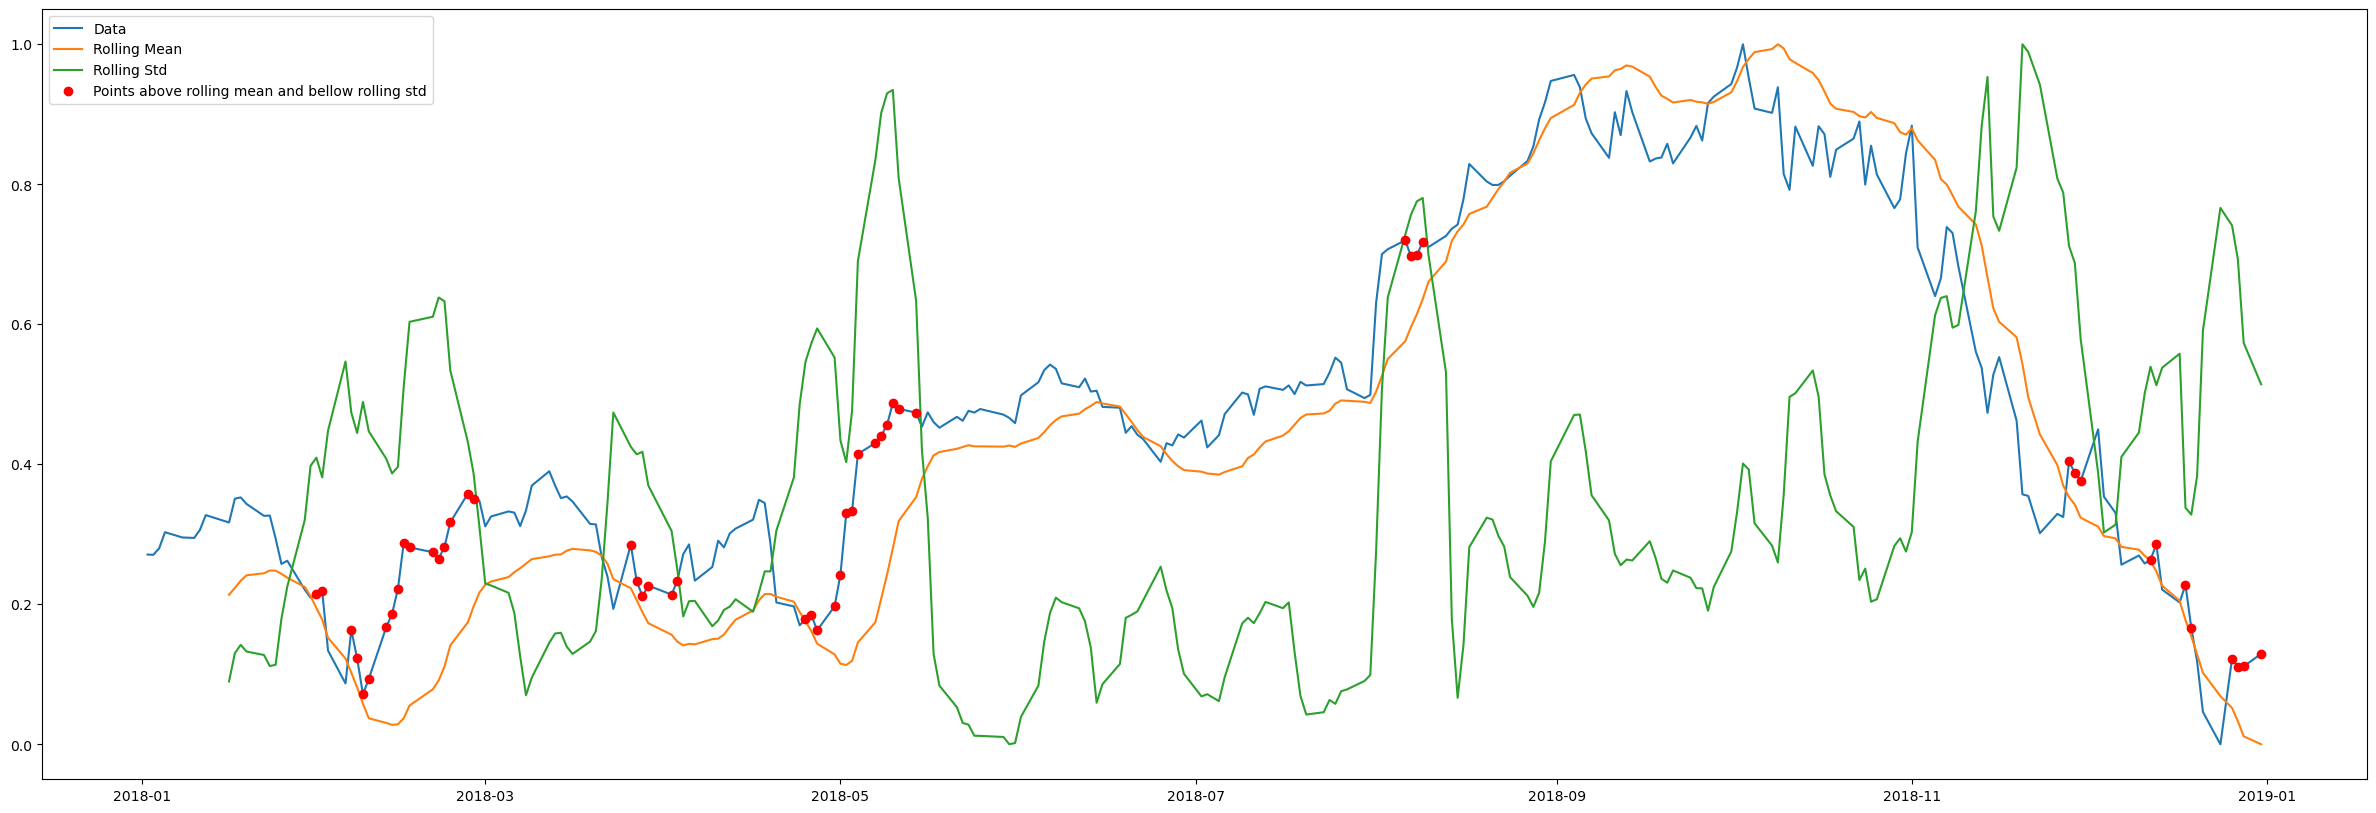

In [9]:
series.plot(window=10, alpha=0.5,  plots = ['bet_std_mean', 'mean', 'std', 'data', 'gradient'])  #'data', 'mean', 'std', 'exponential'
# std works well